# Simulated spectra for signals and noise

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 1

import numpy as np
import scipy.stats
import scipy.fft
import scipy.interpolate
import matplotlib
matplotlib.rcParams['figure.dpi'] = 90

import matplotlib.pyplot as plt

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png','pdf')

# %aimport detectors

# diodes = detectors.diodes
# TIA = detectors.TIA()

rng = np.random.default_rng()

savefig = True
ifig = 1

In [2]:
nsamples = 2048 * 128 * 2
print(f'Signal size = {nsamples}')

f_sample = 2e6  # sample rate, samples/s (Hz)
bw = f_sample / 2
print(f'Signal bandwidth = {bw/1e6:.3f} Mhz')

I_dc = 1.0
I_rms = 1e-2 * I_dc
i2 = I_rms ** 2 / bw
print(f'DC signal = {I_dc:.2f}')
print(f'Noise RMS = {I_rms:.2e}')
print(f'Noise power density = {i2:.2e} 1/Hz')

time_array = np.arange(nsamples) / f_sample

Signal size = 524288
Signal bandwidth = 1.000 Mhz
DC signal = 1.00
Noise RMS = 1.00e-02
Noise power density = 1.00e-10 1/Hz


FFT freq. resolution = 0.977 kHz
N(0,1) samples
  Mean rel. error = 2.38e-05
  RMS rel. error = 9.19e-04
  Normal skew p-value = 0.60 (not std. norm. if ~ 0)
  Normal kurtosis p-value = 0.31 (not std. norm. if ~ 0)
  i2 rel. error = 1.821e-03
IFFT with N(0,1) amp.
  Mean rel. error = 0.00e+00
  RMS rel. error = 3.66e-04
  Normal skew p-value = 0.24 (not std. norm. if ~ 0)
  Normal kurtosis p-value = 1.00 (not std. norm. if ~ 0)
  i2 rel. error = 8.074e-04


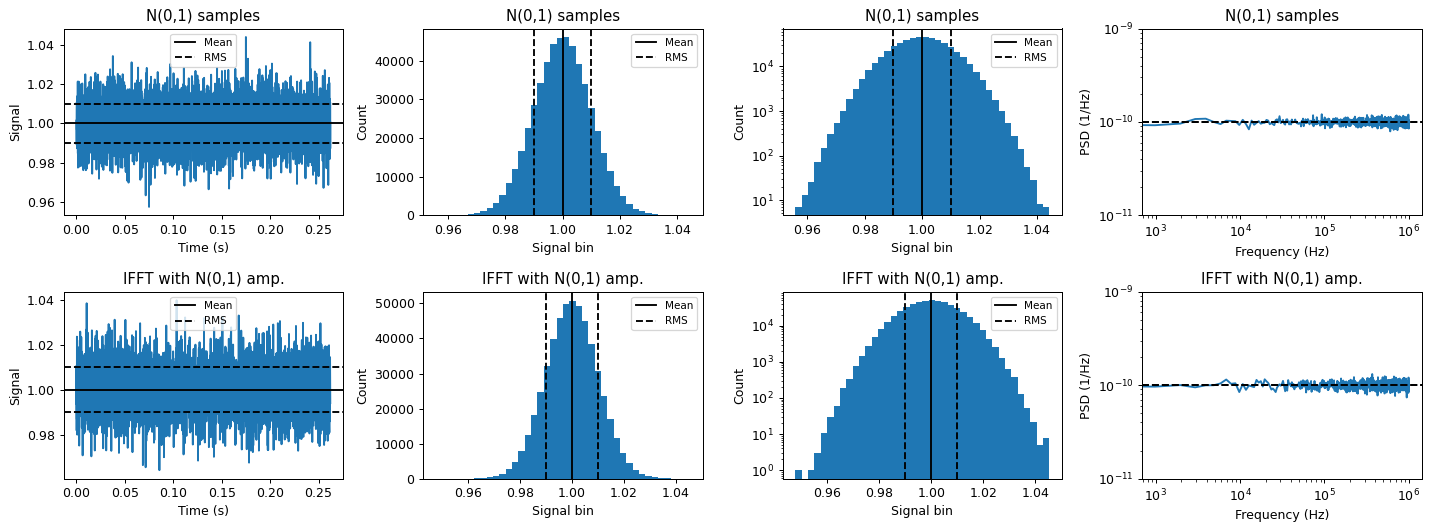

In [3]:
# Signal 1: N(0,1) samples and Irms
s1_name = 'N(0,1) samples'
signal_1 = I_dc + I_rms * rng.standard_normal(nsamples)

# Signal 2 from fourier comp and ifft
s2_name = 'IFFT with N(0,1) amp.'
nfreqs_full = nsamples//2 + 1
freqs_full = scipy.fft.rfftfreq(nsamples, 1/f_sample)
amplitudes = np.sqrt(i2 * bw * nsamples) * rng.standard_normal(nfreqs_full)
amplitudes[0] = I_dc * nsamples
phases = 2*np.pi * rng.random(nfreqs_full)
phases[0] = 0
fourier_comp = amplitudes * np.exp(1.j * phases)
signal_2 = np.real( scipy.fft.irfft(fourier_comp) )

# FFT analysis 
nfft = 2048  # FFT bin size
nbins = nsamples // nfft
freqs = scipy.fft.rfftfreq(nfft, 1/f_sample)
nfreqs = freqs.size
assert(nfreqs == (nfft//2+1))
f_res = freqs[1]  # FFT freq. resolution (Hz)
assert(f_res == f_sample / nfft)
print(f'FFT freq. resolution = {f_res/1e3:.3f} kHz')

ncols, nrows = 4, 2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))
iax = 0
for signal, name in zip([signal_1, signal_2], [s1_name, s2_name]):
    print(name)
    mean = np.mean(signal)
    print(f'  Mean rel. error = {np.abs(mean - I_dc)/I_dc:.2e}')
    rms = np.sqrt(np.mean((signal-mean) ** 2))
    print(f'  RMS rel. error = {np.abs(I_rms-rms) / I_rms:.2e}')

    _, skew_pvalue = scipy.stats.skewtest(signal)
    _, kurtosis_pvalue = scipy.stats.kurtosistest(signal)
    print(f'  Normal skew p-value = {skew_pvalue:.2f} (not std. norm. if ~ 0)')
    print(f'  Normal kurtosis p-value = {kurtosis_pvalue:.2f} (not std. norm. if ~ 0)')

    psd_bins = np.empty([nfreqs, nbins])
    for i in np.arange(nbins):
        # signal_0mean = signal[nfft*i:nfft*(i+1)] - np.mean(signal[nfft*i:nfft*(i+1)])
        rfft = scipy.fft.rfft( signal[nfft*i:nfft*(i+1)] )
        psd_bins[:,i] = np.abs(rfft) ** 2 / bw / nfft
    psd = np.mean(psd_bins, axis=1)
    i2_mean = np.mean(psd[1:])
    i2_rel_error = np.abs(i2_mean - i2) / i2
    print(f'  i2 rel. error = {i2_rel_error:.3e}')

    plt.sca(axes.flat[iax])
    plt.plot(time_array[::100], signal[::100])
    plt.title(name)
    plt.xlabel('Time (s)')
    plt.ylabel('Signal')
    plt.axhline(mean, c='k', ls='-', label='Mean')
    plt.axhline(mean-rms, c='k', ls='--', label='RMS')
    plt.axhline(mean+rms, c='k', ls='--')
    plt.legend(fontsize='small')
    iax += 1

    plt.sca(axes.flat[iax])
    plt.hist(signal, bins=40)
    plt.title(name)
    plt.xlabel('Signal bin')
    plt.ylabel('Count')
    plt.axvline(mean, c='k', ls='-', label='Mean')
    plt.axvline(mean-rms, c='k', ls='--', label='RMS')
    plt.axvline(mean+rms, c='k', ls='--')
    plt.legend(fontsize='small')
    iax += 1

    plt.sca(axes.flat[iax])
    plt.hist(signal, bins=40, log=True)
    plt.title(name)
    plt.xlabel('Signal bin')
    plt.ylabel('Count')
    plt.axvline(mean, c='k', ls='-', label='Mean')
    plt.axvline(mean-rms, c='k', ls='--', label='RMS')
    plt.axvline(mean+rms, c='k', ls='--')
    plt.legend(fontsize='small')
    iax += 1

    plt.sca(axes.flat[iax])
    plt.loglog(freqs, psd)
    plt.title(name)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (1/Hz)')
    plt.ylim(i2*1e-1,i2*1e1)
    plt.axhline(i2_mean, c='k', ls='--')
    plt.axhline(i2, c='k', ls='--')
    iax += 1

plt.tight_layout()

DC signal = 1.00
Noise RMS = 1.00e-02
Mean i2 = 1.00e-10 1/Hz
IFFT with N(0,1) amp.
  Mean rel. error = 0.00e+00
  RMS rel. error = 8.92e-04
  Normal skew p-value = 0.54 (not std. norm. if ~ 0)
  Normal kurtosis p-value = 0.09 (not std. norm. if ~ 0)


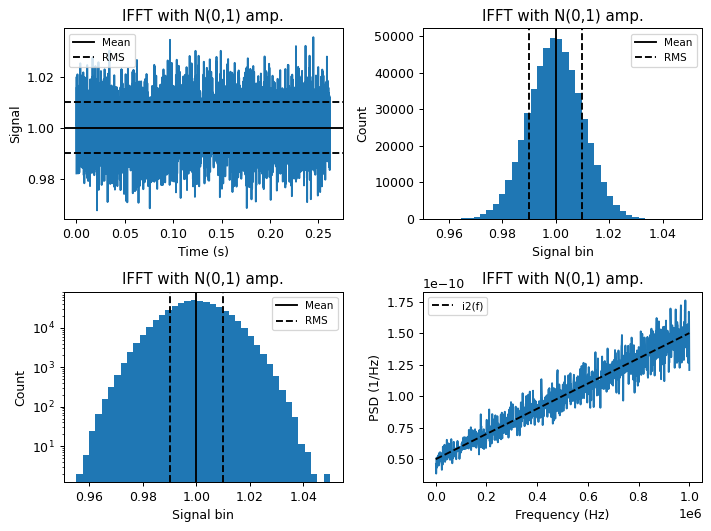

In [4]:
I_dc = 1.0
I_rms = 1e-2 * I_dc
print(f'DC signal = {I_dc:.2f}')
print(f'Noise RMS = {I_rms:.2e}')

i2_f_rel = np.linspace(1,3,nfreqs_full)
i2_mean = I_rms**2 / bw
print(f'Mean i2 = {i2_mean:.2e} 1/Hz')
i2_f = i2_mean * i2_f_rel / np.mean(i2_f_rel)

# signal 3 from fourier comp and ifft
s3_name = 'IFFT with N(0,1) amp.'
amplitudes = np.sqrt( i2_f * bw * nsamples) * rng.standard_normal(nfreqs_full)
amplitudes[0] = I_dc * nsamples
phases = 2*np.pi * rng.random(nfreqs_full)
phases[0] = 0
fourier_comp = amplitudes * np.exp(1.j * phases)
signal_3 = np.real( scipy.fft.irfft(fourier_comp) )

ncols, nrows = 2,2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))
iax = 0
for signal, name in zip([signal_3], [s3_name]):
    print(name)
    mean = np.mean(signal)
    print(f'  Mean rel. error = {np.abs(mean - I_dc)/I_dc:.2e}')
    rms = np.sqrt(np.mean((signal-mean) ** 2))
    print(f'  RMS rel. error = {np.abs(I_rms-rms) / I_rms:.2e}')

    _, skew_pvalue = scipy.stats.skewtest(signal)
    _, kurtosis_pvalue = scipy.stats.kurtosistest(signal)
    print(f'  Normal skew p-value = {skew_pvalue:.2f} (not std. norm. if ~ 0)')
    print(f'  Normal kurtosis p-value = {kurtosis_pvalue:.2f} (not std. norm. if ~ 0)')

    psd = np.empty([nfreqs, nbins])
    for i in np.arange(nbins):
        # signal_0mean = signal[nfft*i:nfft*(i+1)] - np.mean(signal[nfft*i:nfft*(i+1)])
        rfft = scipy.fft.rfft( signal[nfft*i:nfft*(i+1)] )
        psd[:,i] = np.abs(rfft) ** 2 / bw / nfft
    psd_mean = np.mean(psd, axis=1)

    plt.sca(axes.flat[iax])
    plt.plot(time_array[::100], signal[::100])
    plt.title(name)
    plt.xlabel('Time (s)')
    plt.ylabel('Signal')
    plt.axhline(mean, c='k', ls='-', label='Mean')
    plt.axhline(mean-rms, c='k', ls='--', label='RMS')
    plt.axhline(mean+rms, c='k', ls='--')
    plt.legend(fontsize='small')
    iax += 1

    plt.sca(axes.flat[iax])
    plt.hist(signal, bins=40)
    plt.title(name)
    plt.xlabel('Signal bin')
    plt.ylabel('Count')
    plt.axvline(mean, c='k', ls='-', label='Mean')
    plt.axvline(mean-rms, c='k', ls='--', label='RMS')
    plt.axvline(mean+rms, c='k', ls='--')
    plt.legend(fontsize='small')
    iax += 1

    plt.sca(axes.flat[iax])
    plt.hist(signal, bins=40, log=True)
    plt.title(name)
    plt.xlabel('Signal bin')
    plt.ylabel('Count')
    plt.axvline(mean, c='k', ls='-', label='Mean')
    plt.axvline(mean-rms, c='k', ls='--', label='RMS')
    plt.axvline(mean+rms, c='k', ls='--')
    plt.legend(fontsize='small')
    iax += 1

    plt.sca(axes.flat[iax])
    plt.plot(freqs[1:], psd_mean[1:])
    plt.plot(freqs_full, i2_f, 
        c='k', ls='--', label='i2(f)')
    plt.title(name)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (1/Hz)')
    # plt.ylim(i2_f.mean()*1e-2,i2_f.mean()*1e1)
    # plt.xlim(freqs[1], bw)
    plt.legend(fontsize='small')
    iax += 1

plt.tight_layout()

DC signal = 1.00
Noise RMS = 1.00e-02
Mean i2 = 1.00e-10 1/Hz
IFFT with N(0,1) amp.
  Mean rel. error = 0.00e+00
  RMS = 1.02e-02
  RMS rel. error = 1.04e-03
  Normal skew p-value = 0.61 (not std. norm. if ~ 0)
  Normal kurtosis p-value = 0.02 (not std. norm. if ~ 0)


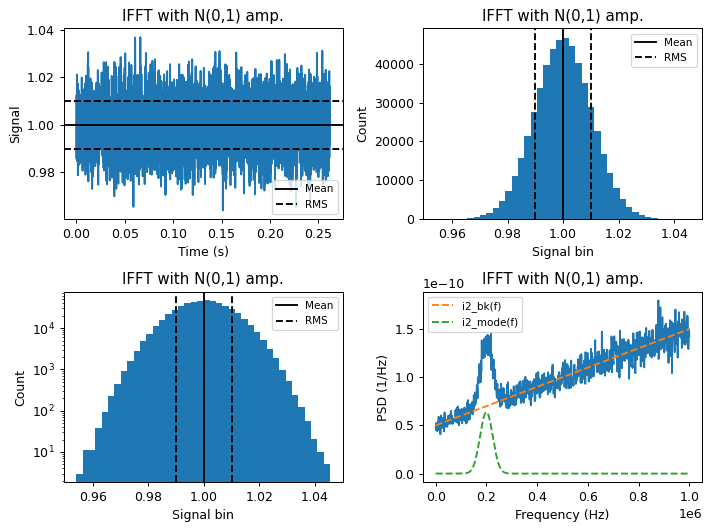

In [5]:
I_dc = 1.0
I_rms = 1e-2 * I_dc
print(f'DC signal = {I_dc:.2f}')
print(f'Noise RMS = {I_rms:.2e}')

i2_f_rel = np.linspace(1,3,nfreqs_full)
i2_mean = I_rms**2 / bw
print(f'Mean i2 = {i2_mean:.2e} 1/Hz')
i2_f = i2_mean * i2_f_rel / np.mean(i2_f_rel)

I_rms_mode = 2e-3 * I_dc
i2_mean_mode = I_rms_mode**2 / bw
f0 = 200e3
sigma_f = 25e3
i2_f_mode_rel = np.exp(-0.5*(freqs_full-f0)**2 / sigma_f**2)
i2_f_mode = i2_mean_mode * i2_f_mode_rel / np.mean(i2_f_mode_rel)

i2_total = i2_mean + i2_mean_mode

# signal 3 from fourier comp and ifft
s3_name = 'IFFT with N(0,1) amp.'
amplitudes = np.sqrt( i2_f * bw * nsamples) * rng.standard_normal(nfreqs_full)
amplitudes[0] = I_dc * nsamples
phases = 2*np.pi * rng.random(nfreqs_full) 
phases[0] = 0
fourier_comp = amplitudes * np.exp(1.j * phases)

amplitudes = np.sqrt( i2_f_mode * bw * nsamples) * rng.standard_normal(nfreqs_full)
amplitudes[0] = 0
phases = 2*np.pi * rng.random(nfreqs_full) 
phases[0] = 0
fourier_comp = fourier_comp + amplitudes * np.exp(1.j * phases)

signal_3 = np.real( scipy.fft.irfft(fourier_comp) )

ncols, nrows = 2,2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))
iax = 0
for signal, name in zip([signal_3], [s3_name]):
    print(name)
    mean = np.mean(signal)
    print(f'  Mean rel. error = {np.abs(mean - I_dc)/I_dc:.2e}')
    rms = np.sqrt(np.mean((signal-mean) ** 2))
    I_rms_total = np.sqrt(I_rms**2+I_rms_mode**2)
    print(f'  RMS = {rms:.2e}')
    print(f'  RMS rel. error = {np.abs(I_rms_total-rms) / I_rms_total:.2e}')

    _, skew_pvalue = scipy.stats.skewtest(signal)
    _, kurtosis_pvalue = scipy.stats.kurtosistest(signal)
    print(f'  Normal skew p-value = {skew_pvalue:.2f} (not std. norm. if ~ 0)')
    print(f'  Normal kurtosis p-value = {kurtosis_pvalue:.2f} (not std. norm. if ~ 0)')

    psd = np.empty([nfreqs, nbins])
    for i in np.arange(nbins):
        # signal_0mean = signal[nfft*i:nfft*(i+1)] - np.mean(signal[nfft*i:nfft*(i+1)])
        rfft = scipy.fft.rfft( signal[nfft*i:nfft*(i+1)] )
        psd[:,i] = np.abs(rfft) ** 2 / bw / nfft
    psd_mean = np.mean(psd, axis=1)

    plt.sca(axes.flat[iax])
    plt.plot(time_array[::100], signal[::100])
    plt.title(name)
    plt.xlabel('Time (s)')
    plt.ylabel('Signal')
    plt.axhline(mean, c='k', ls='-', label='Mean')
    plt.axhline(mean-rms, c='k', ls='--', label='RMS')
    plt.axhline(mean+rms, c='k', ls='--')
    plt.legend(fontsize='small')
    iax += 1

    plt.sca(axes.flat[iax])
    plt.hist(signal, bins=40)
    plt.title(name)
    plt.xlabel('Signal bin')
    plt.ylabel('Count')
    plt.axvline(mean, c='k', ls='-', label='Mean')
    plt.axvline(mean-rms, c='k', ls='--', label='RMS')
    plt.axvline(mean+rms, c='k', ls='--')
    plt.legend(fontsize='small')
    iax += 1

    plt.sca(axes.flat[iax])
    plt.hist(signal, bins=40, log=True)
    plt.title(name)
    plt.xlabel('Signal bin')
    plt.ylabel('Count')
    plt.axvline(mean, c='k', ls='-', label='Mean')
    plt.axvline(mean-rms, c='k', ls='--', label='RMS')
    plt.axvline(mean+rms, c='k', ls='--')
    plt.legend(fontsize='small')
    iax += 1

    plt.sca(axes.flat[iax])
    plt.plot(freqs[1:], psd_mean[1:])
    plt.plot(freqs_full, i2_f, 
        c='C1', ls='--', label='i2_bk(f)')
    plt.plot(freqs_full, i2_f_mode, 
        c='C2', ls='--', label='i2_mode(f)')
    plt.title(name)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (1/Hz)')
    # plt.ylim(i2_total*1e-1,i2_total*1e1)
    # plt.xlim(freqs[1], bw)
    plt.legend(fontsize='small')
    iax += 1

plt.tight_layout()